In [15]:
import numpy as np
# Importing Pandas Library 
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing import *
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from utils import *

from tensorflow.keras.models import Model, load_model

from models.EEGNet import *

from sklearn.metrics import confusion_matrix

from preprocessing import *

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
model = load_model(r'.\checkpoints\orthogonal_2.keras')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ eyebrows input      │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left input          │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right input         │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ both input          │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teeth input         │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eyebrows            │ (None, 64)        │      2,848 │ eyebrows          │
│ (Functional)        │                   │            │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left (Functional)   │ (None, 64)        │      2,848 │ left input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right (Functional)  │ (None, 40)        │      1,160 │ right input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ both (Functional)   │ (None, 128)       │     12,608 │ both input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teeth (Functional)  │ (None, 128)       │     10,624 │ teeth input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 424)       │          0 │ eyebrows[0][0],   │
│ (Concatenate)       │                   │            │ left[0][0],       │
│                     │                   │            │ right[0][0],      │
│                     │                   │            │ both[0][0],       │
│                     │                   │            │ teeth[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 768)       │    326,400 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 6)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax             │ (None, 128, 6)    │          0 │ reshape[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,066,874 (4.07 MB)

 Trainable params: 355,192 (1.35 MB)

 Non-trainable params: 1,296 (5.06 KB)

 Optimizer params: 710,386 (2.71 MB)

In [18]:
df_eyebrows = pd.read_csv(r'.\inference_data\eyebrows.csv').drop(columns=['timestamps', 'Right AUX'])
df_left = pd.read_csv(r'.\inference_data\left.csv').drop(columns=['timestamps', 'Right AUX'])
df_right = pd.read_csv(r'.\inference_data\right.csv').drop(columns=['timestamps', 'Right AUX'])
df_both = pd.read_csv(r'.\inference_data\both.csv').drop(columns=['timestamps', 'Right AUX'])
df_teeth = pd.read_csv(r'.\inference_data\teeth.csv').drop(columns=['timestamps', 'Right AUX'])

In [19]:
label_name = ['eyebrows', 'left', 'right', 'both', 'teeth']
scalers = {}
for label in label_name:
    scalers[label] = joblib.load(rf'.\pipeline_{label}\checkpoints\scaler.save')

In [20]:
filters = {
    'left': filter_left,
    'right': filter_right,
    'both': filter_both,
    'teeth': filter_teeth,
    'eyebrows': filter_eyebrows,
}

In [21]:
def get_input(df):
    time_step = 128
    data = df.to_numpy()
    input_data = []
    
    for i in range(0, data.shape[0] // time_step * time_step, time_step):
        x_eyebrows = pipeline(data, filters['eyebrows'], scalers['eyebrows'], i, time_step)
        x_left = pipeline(data, filters['left'], scalers['left'], i, time_step)
        x_right = pipeline(data, filters['right'], scalers['right'], i, time_step)
        x_both = pipeline(data, filters['both'], scalers['both'], i, time_step)
        x_teeth = pipeline(data, filters['teeth'], scalers['teeth'], i, time_step)
        input_data.append(
            np.concatenate(
                [
                    x_eyebrows,
                    x_left,
                    x_right,
                    x_both,
                    x_teeth
                ],
                axis=1
            )
        )

    input_data = np.array(input_data)
    input_data = input_data[:, :, :, np.newaxis]
    input_data = input_data.transpose(0, 2, 1, 3)
    print(input_data.shape)
    
    return data, np.array(input_data)

In [22]:
def get_output(input_data):
    y_pred = model.predict([
        input_data[:, :4], 
        input_data[:, 4:8], 
        input_data[:, 8:12],
        input_data[:, 12:16],
        input_data[:, 16:20]
    ])
    y_pred = np.argmax(y_pred, axis=2)
    y_pred = np.concatenate(y_pred, axis=0)
    y_pred_onehot = np.zeros((y_pred.size, 6))
    y_pred_onehot[np.arange(y_pred.size), y_pred] = 1

    return y_pred_onehot

In [23]:
def plot_data_result(data, y_pred_onehot, title):
    plt.figure(figsize=(50, 30)).suptitle(title, fontsize=40)
    plt.subplot(9, 1, 1)
    plt.title("TP9", fontsize=40)
    plt.plot(data[:, 0])
    plt.subplot(9, 1, 2)
    plt.title("AF7", fontsize=40)
    plt.plot(data[:, 1])
    plt.subplot(9, 1, 3)
    plt.title("AF8", fontsize=40)
    plt.plot(data[:, 2])
    plt.subplot(9, 1, 4)
    plt.title("TP10", fontsize=40)
    plt.plot(data[:, 3])
    plt.subplot(9, 1, 5)
    plt.title("Result eyebrows", fontsize=40)
    plt.plot(y_pred_onehot[:, 1])
    plt.subplot(9, 1, 6)
    plt.title("Result left", fontsize=40)
    plt.plot(y_pred_onehot[:, 2])
    plt.subplot(9, 1, 7)
    plt.title("Result right", fontsize=40)
    plt.plot(y_pred_onehot[:, 3])
    plt.subplot(9, 1, 8)
    plt.title("Result both", fontsize=40)
    plt.plot(y_pred_onehot[:, 4])
    plt.subplot(9, 1, 9)
    plt.title("Result teeth", fontsize=40)
    plt.plot(y_pred_onehot[:, 5])

(70, 20, 128, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


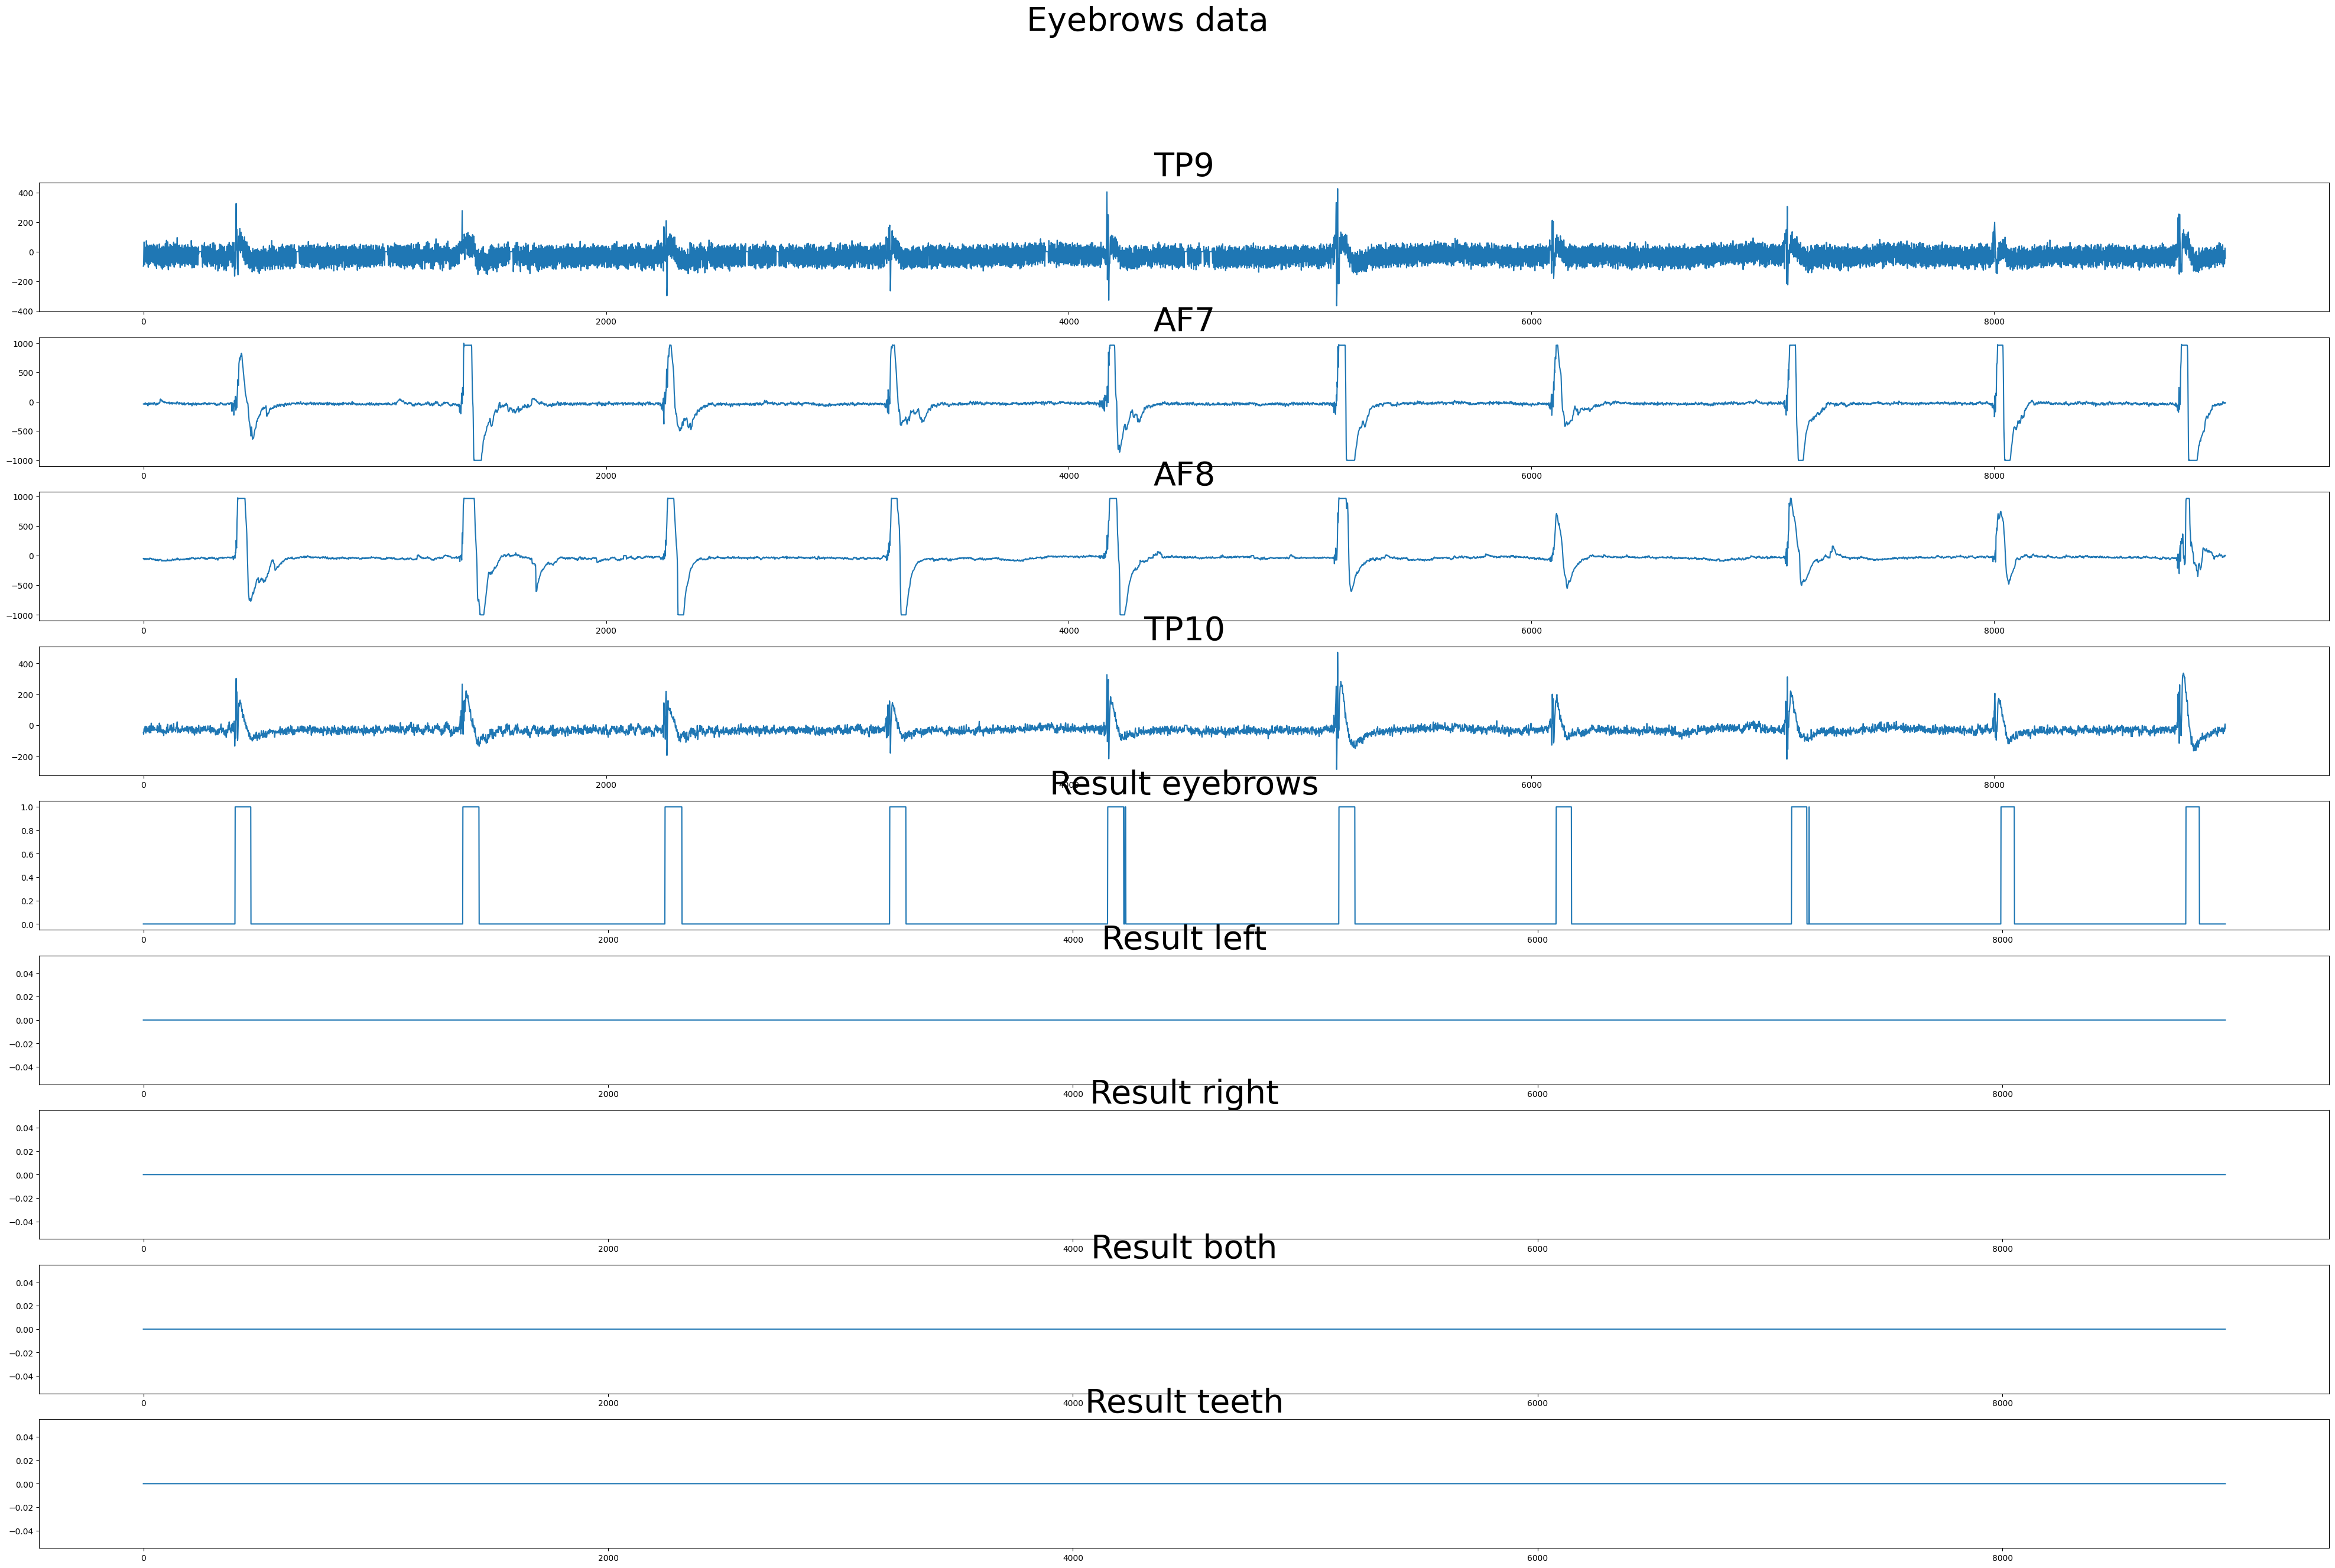

In [24]:
data, input_data = get_input(df_eyebrows)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Eyebrows data")

(70, 20, 128, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


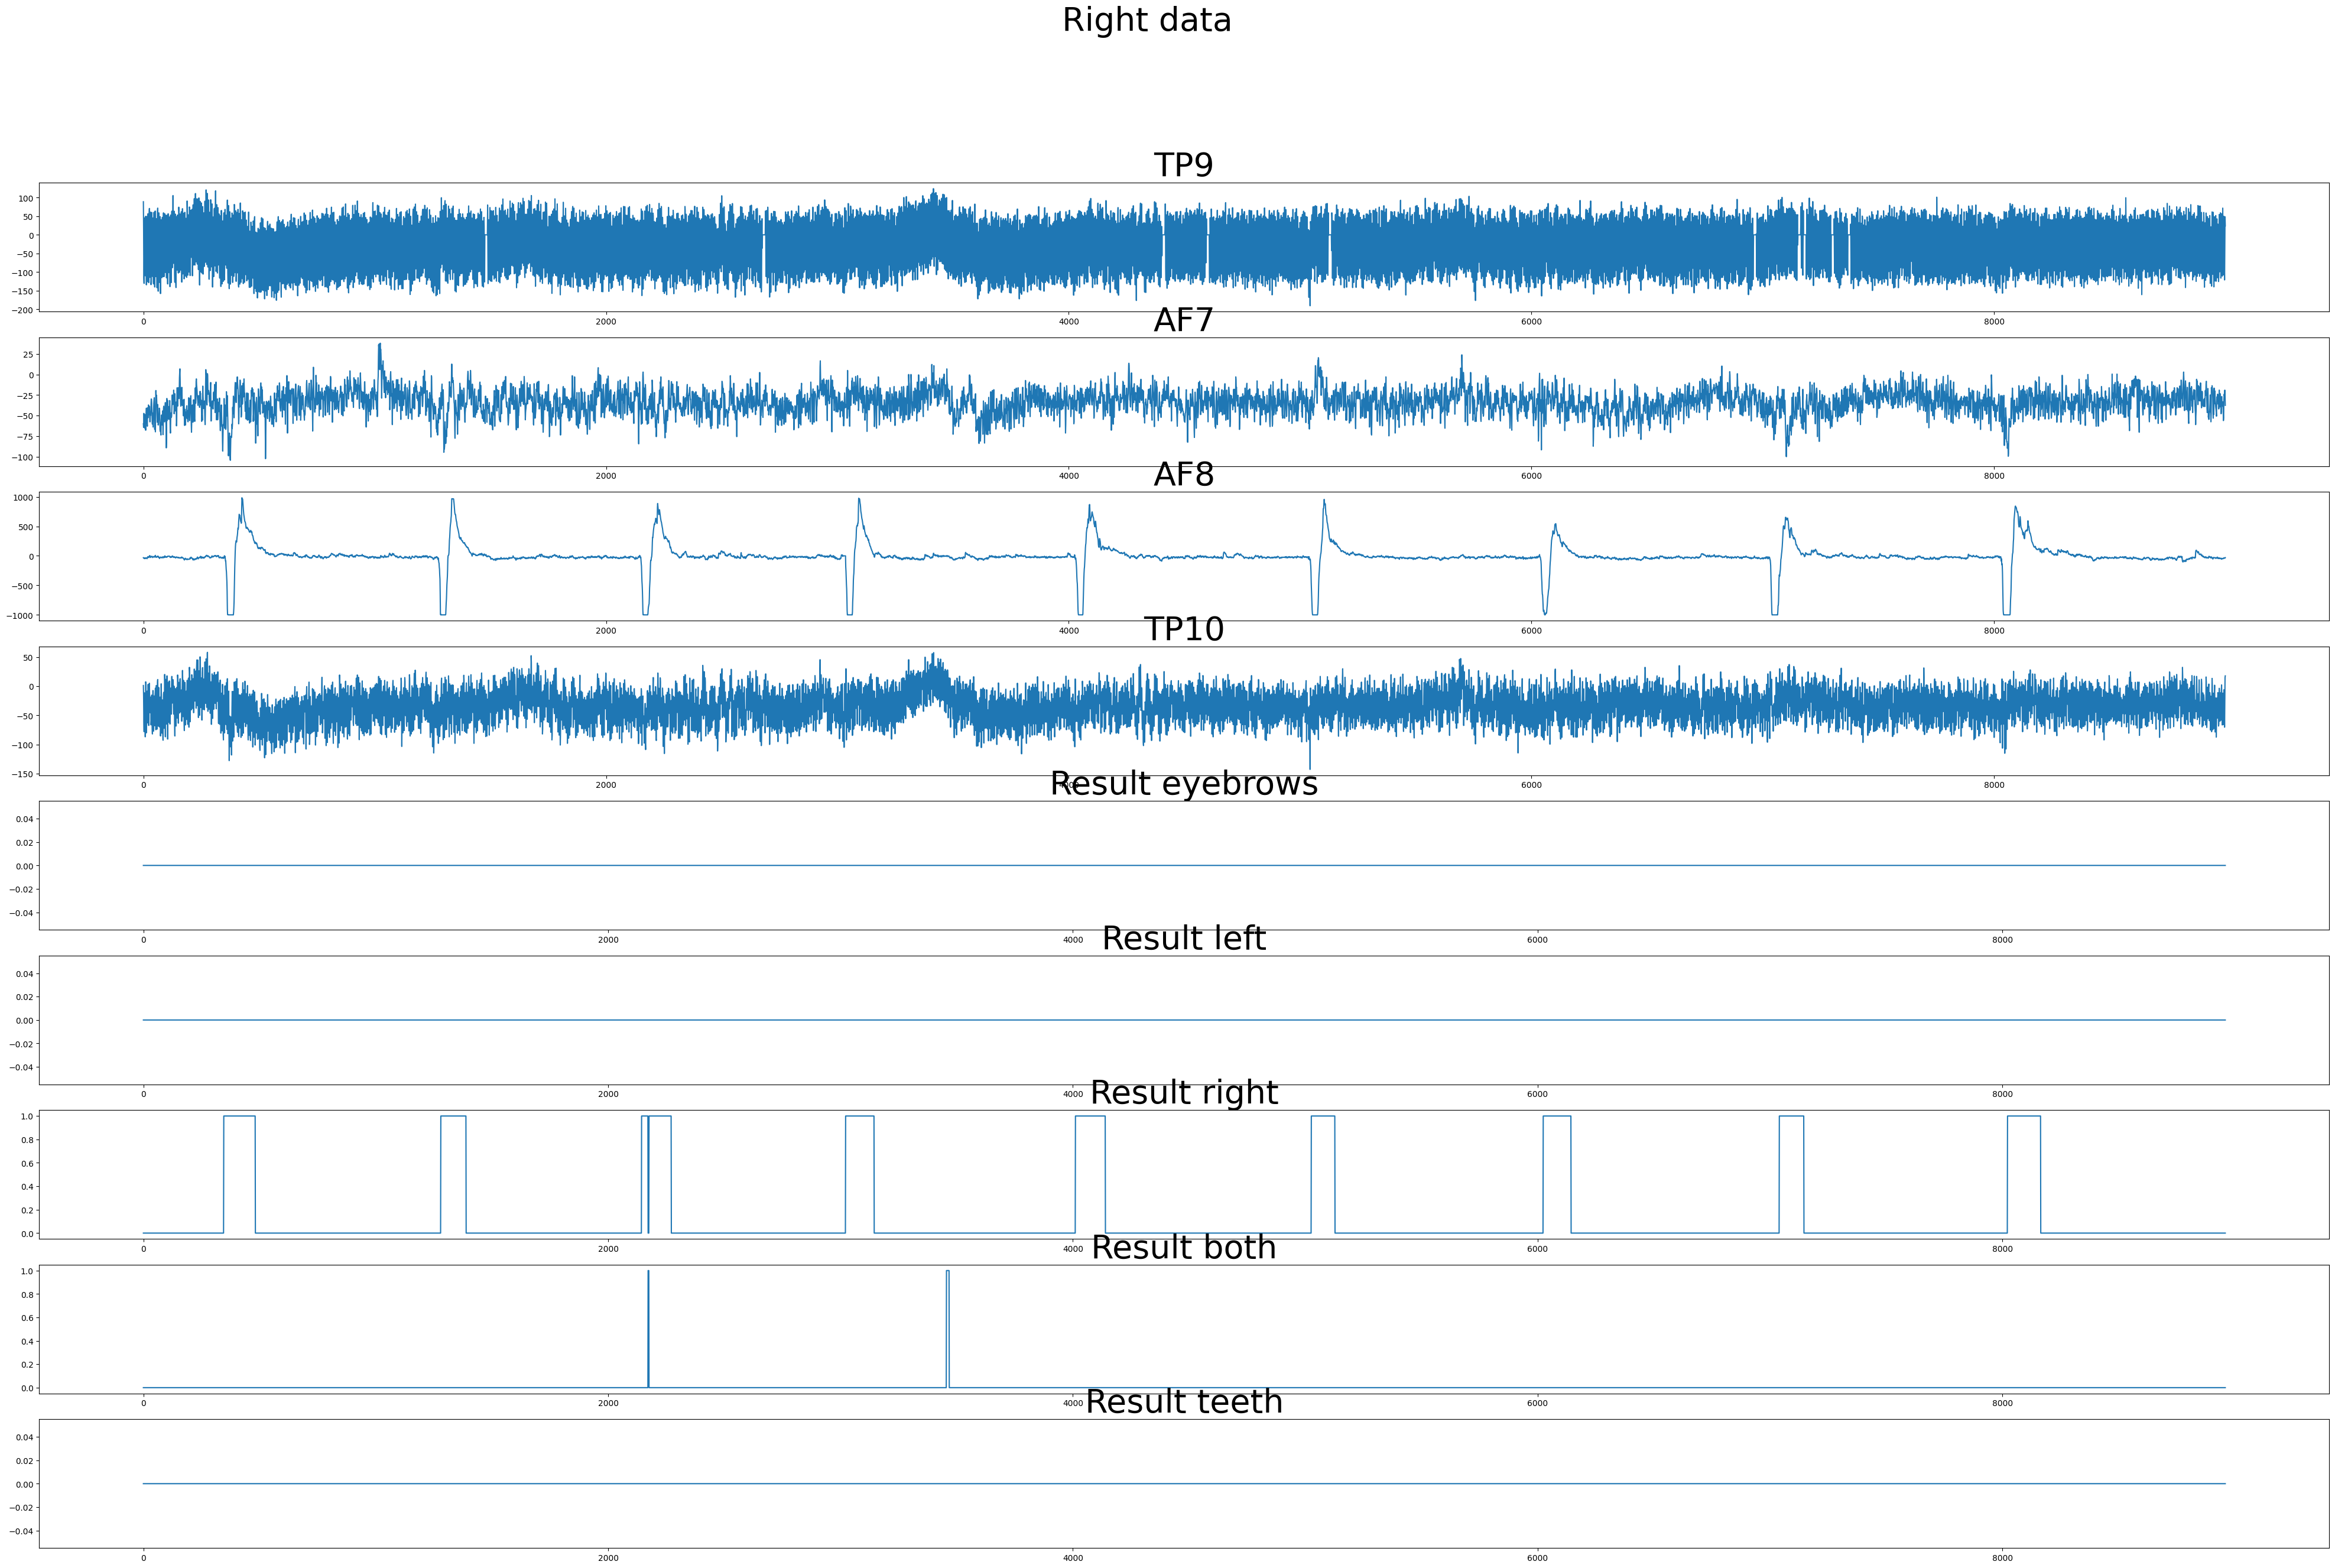

In [25]:
# Eyebrows inference dataset
data, input_data = get_input(df_right)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Right data")

(70, 20, 128, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


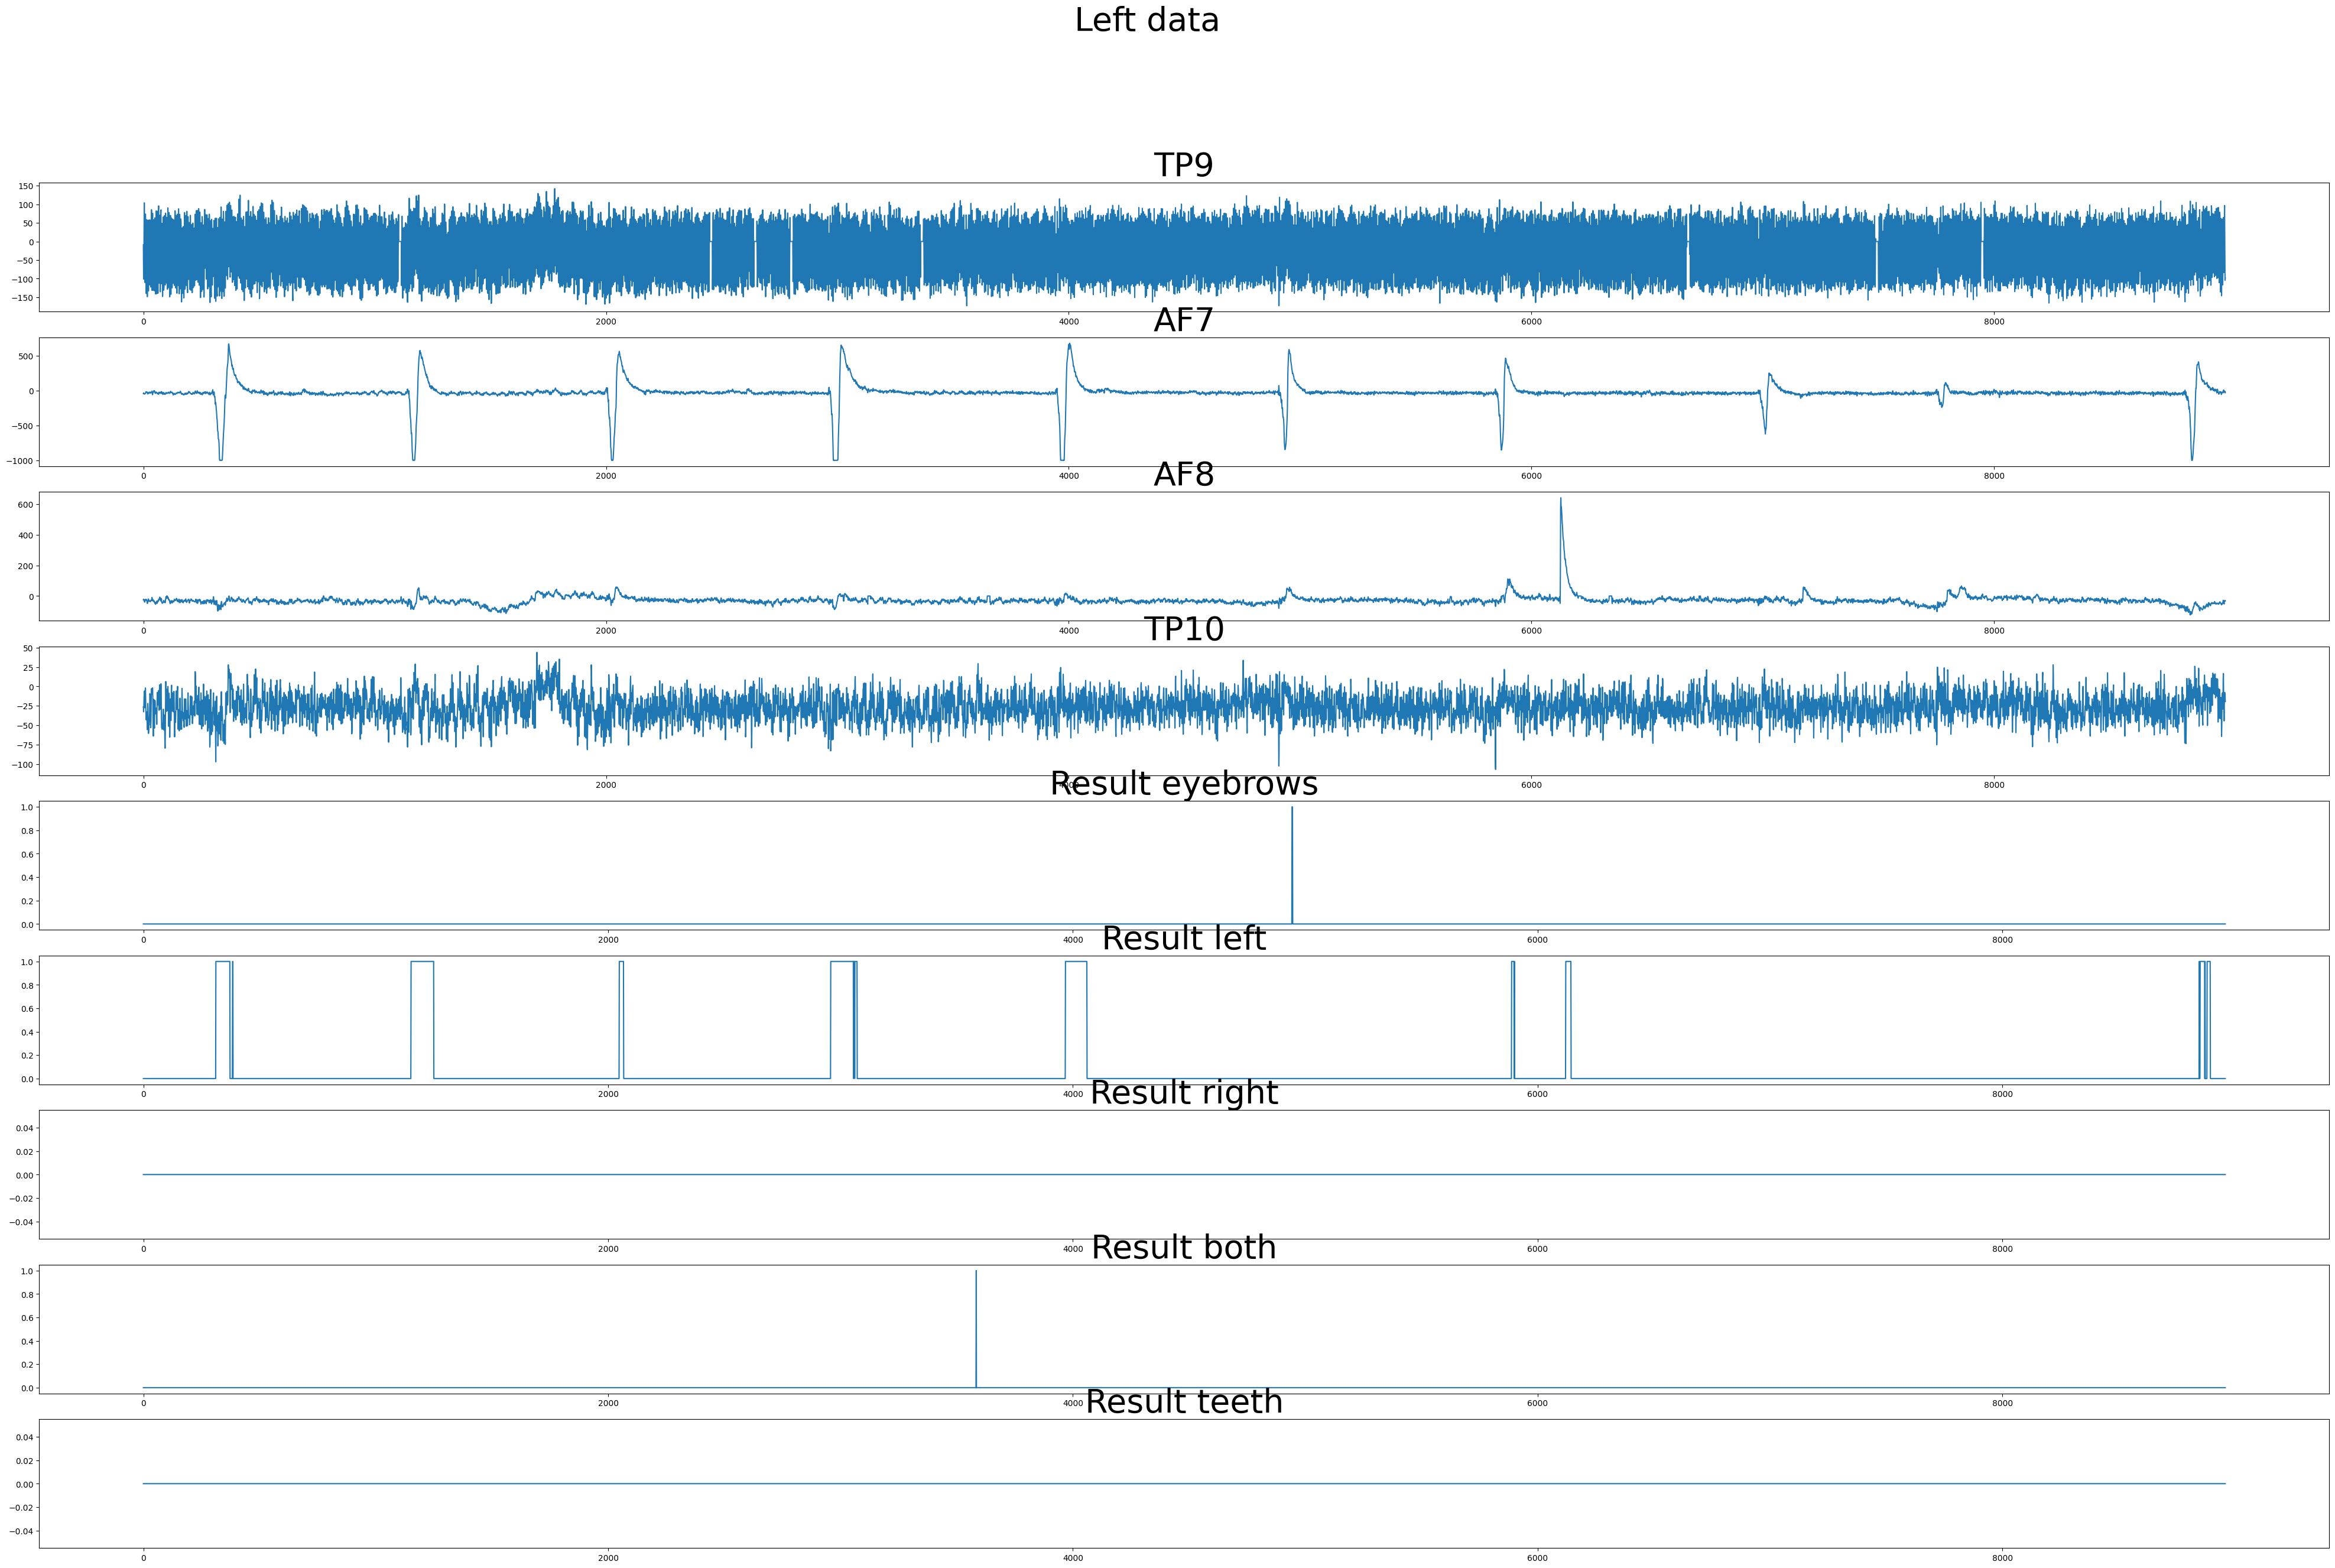

In [26]:
# Eyebrows inference dataset
data, input_data = get_input(df_left)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Left data")

(80, 20, 128, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


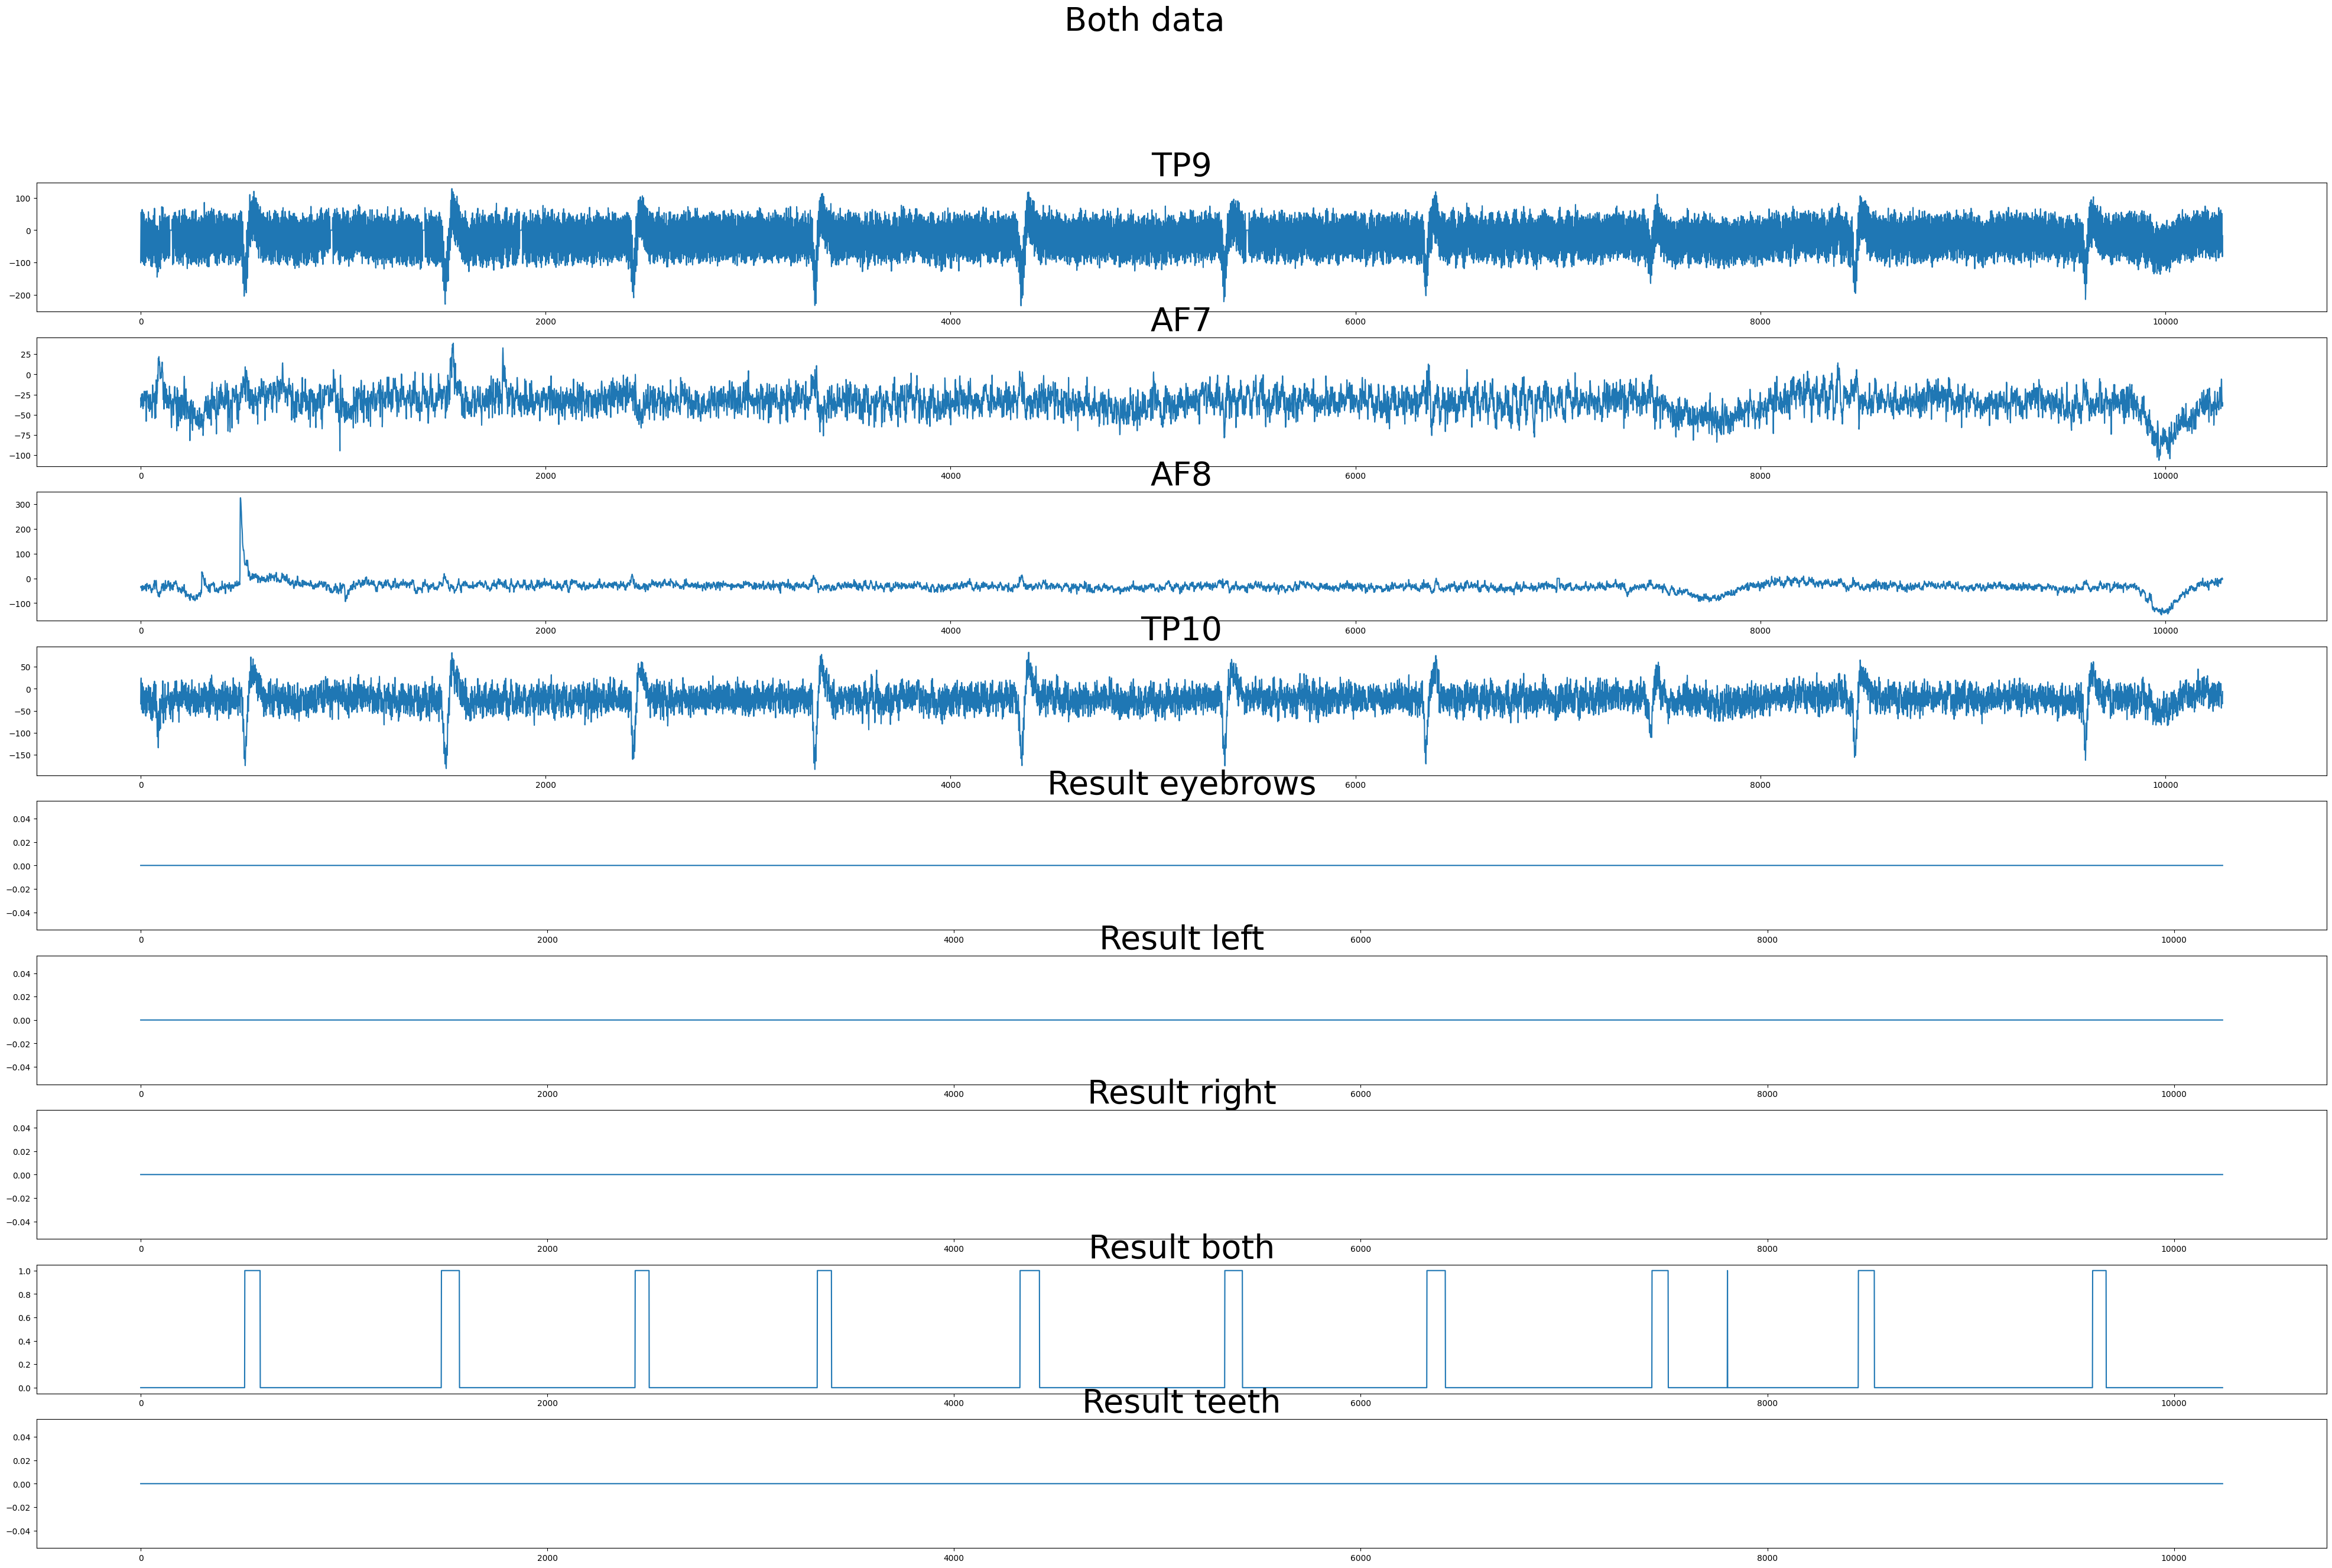

In [27]:
# Eyebrows inference dataset
data, input_data = get_input(df_both)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Both data")

(60, 20, 128, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


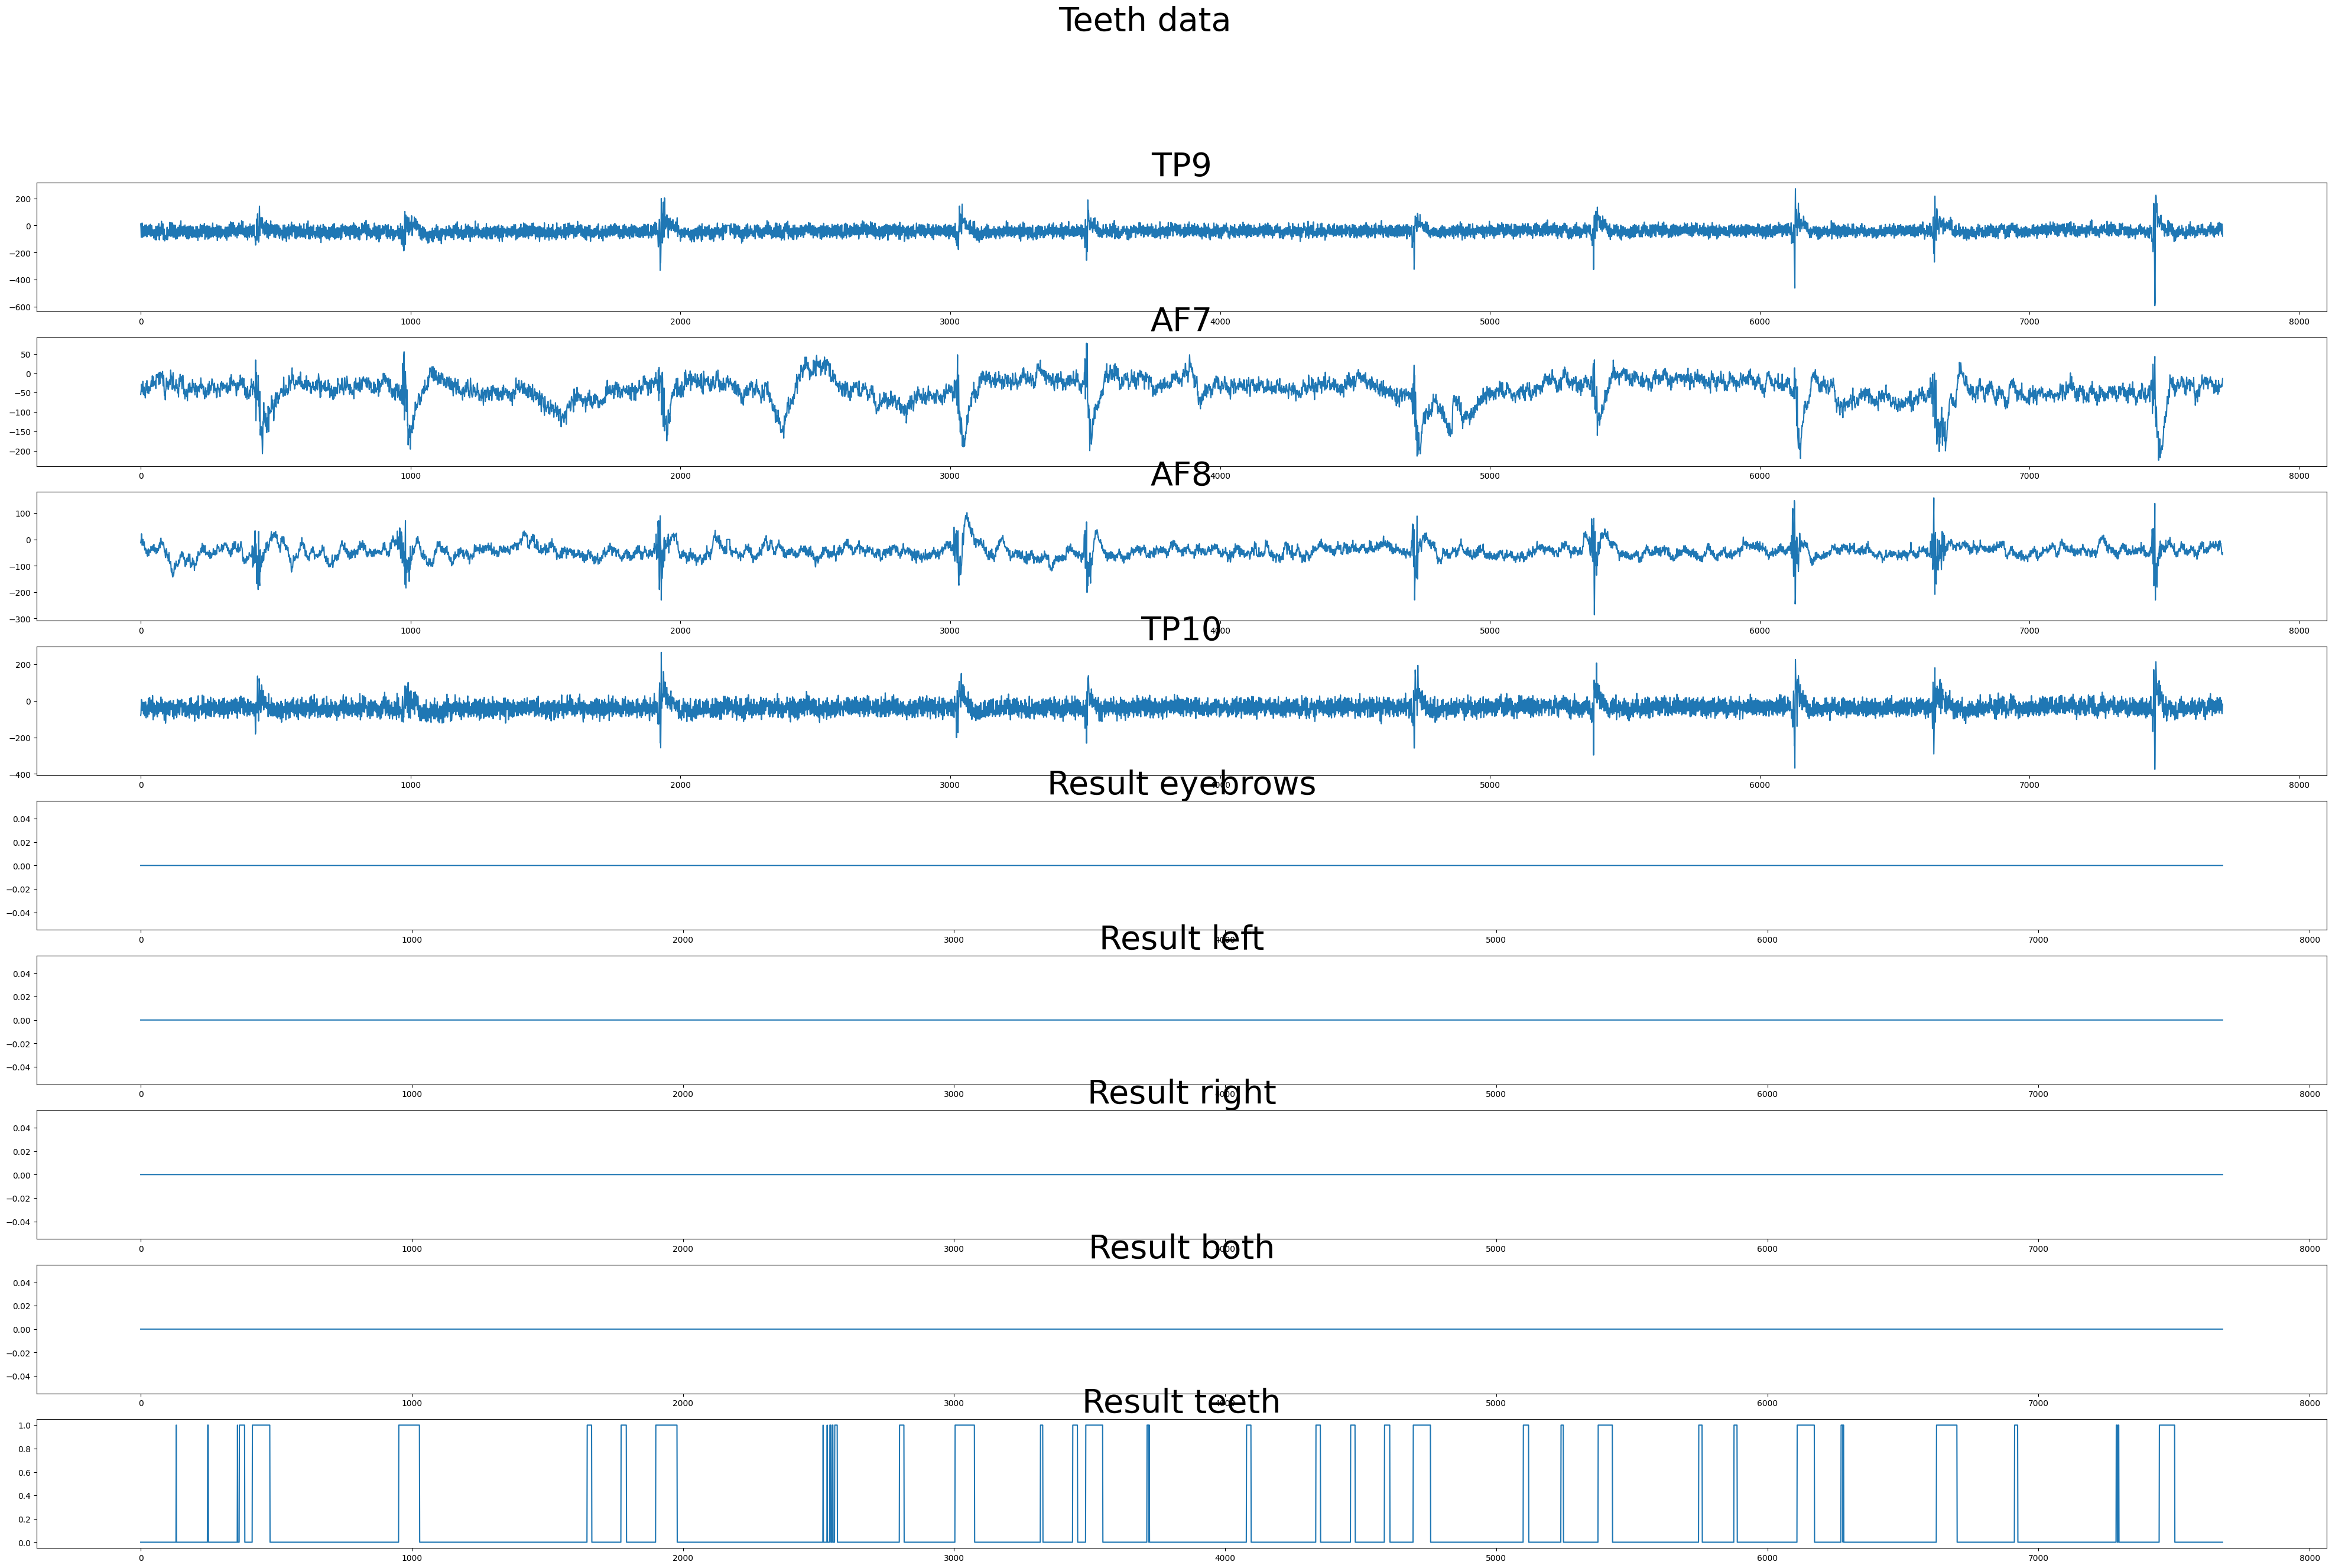

In [28]:
# Eyebrows inference dataset
data, input_data = get_input(df_teeth)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Teeth data")